## Initialisation

### Dependencies

#### Third party

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

#### Personal notebook

/home/poski/Desktop/btp/engineering_strain_stress.ipynb:99: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  {
/home/poski/Desktop/btp/engineering_strain_stress.ipynb:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "cell_type": "markdown",


Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 0.01
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 210
Young's Modulus: 28.283327998342962 GPa
Yield Strength: 236.470693 MPa
Ultimate Tensile Strength is 362.20079200000004 MPa at 18.095% elongation.


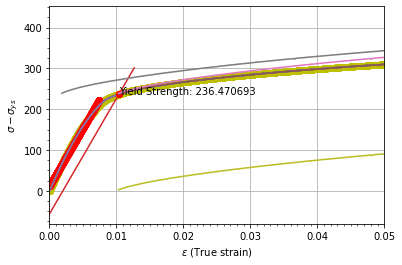

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    save_parameter,
    save_fig,
)
from ipynb.fs.full.true_strain_stress import (
    true_plastic_strain,
    true_stress,
    true_strain,
)
from ipynb.fs.full.engineering_strain_stress import (
    yield_strength,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress
- $\sigma_{s} \rightarrow$ Saturation stress
- $\theta_{0} \rightarrow$ Initial work hardening rate
- $\sigma_{v} \rightarrow$ Scaling stress

## Voce equation

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{\theta_{0}}{\sigma_{v}}\right) \epsilon_{pl} \right)  $$

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{k_{2}}{2}\right) \epsilon_{pl} \right) \because \frac{\theta_{0}}{\sigma_{v}} = \frac{k_{2}}{2}$$

$ \therefore $ Therefore only two fitting parameters ($ k_{2} $ and $ \sigma_{s} $) are necessary to describe the work hardening behaviour at a given temperature.

Saturation stress: -17305480.072996058 MPa
k2: 0.0004427745847488238


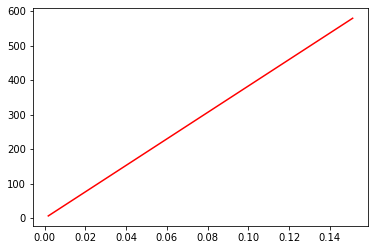

In [13]:
def fit_voce(x, sigma_s, k2):
    return sigma_s*(1-np.exp((k2/2)*x))

rhs_theoretical_voce = curve_fit(
    fit_voce, true_plastic_strain, true_stress, None, method='lm', maxfev=2000
)

popt, _ = rhs_theoretical_voce
sigma_s = popt[0]
k2 = popt[1]
_ = plt.plot(true_plastic_strain, [fit_voce(pl,sigma_s,k2) for pl in true_plastic_strain], 'r')

print(f'Saturation stress: {sigma_s} MPa')
print(f'k2: {k2}')

save_parameter('Saturation stress', sigma_s, 'MPa', f'{OUTPUT_DIR}/output.txt')
save_parameter('k2', k2, '', f'{OUTPUT_DIR}/output.txt')